# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 


## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the no.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```


as opposed to just 

use the no.nansum etc
```
np.mean(mtarides)
np.sum(mtarides)
```

In [150]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import pylab as pl
from __future__ import print_function
plt.style.use('bmh')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [151]:
mtarides = np.load('MTA_Fare.npy')
mtarides.shape
#if not load
#mtarides = np.load(os.getenv("PUIDATA") + '/MTA_Fare.npy')

(600, 23, 194)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

### Date wrangling

In [152]:
# replace -1 with NaN
mtarides = np.where(mtarides == -1, np.nan, mtarides)

In [9]:
#calculate mean per week
mta_ride = np.nanmean(mtarides, axis=0)
mta_weekly = np.nanmean(mta_ride, axis=0)
mta_weekly.shape
#mta_ride.shape

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(194,)

In [10]:
#194 weeks
Date = pd.date_range('5/21/2010',periods = 194, freq = 'w')

In [11]:
# create dateframe and add time series
weeklymean = DataFrame(mta_weekly, index=Date, columns={'Weely_Rides_Mean'} )

In [12]:
weeklymean.head()

,Weely_Rides_Mean
2010-05-23,2628.912534
2010-05-30,2885.621278
2010-06-06,2906.066071
2010-06-13,2885.096407
2010-06-20,2859.107367


### Observe the data:

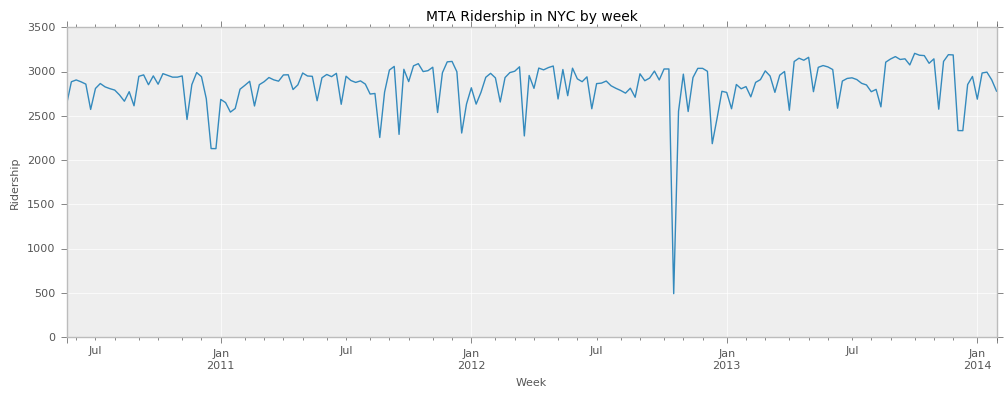

In [134]:
#draft plot
ax = weeklymean.plot(figsize=(12,4), fontsize=8, linewidth=1.0, legend=False)
ax.set_title('MTA Ridership in NYC by week', fontsize=10)
ax.set_xlabel('Week', fontsize=8)
ax.set_ylabel('Ridership', fontsize=8)

Figure 1: Mean of weekly rides, MTA data. Identify a dip around Oct 2012. 

### Set the threshold to find significant event: 
the mean and stardand deviation of the time series can be used to set a 3-sigma threshold, every value that is more then 3 sigma's away from the mean will be flagged as an event. In this case, the most prominent one that is 3 sigma below threshold:

In [14]:
thresholds = mta_weekly.mean() + 3 * mta_weekly.std(), mta_weekly.mean() - 3 * mta_weekly.std()
print ('Thresholds:', thresholds)

Thresholds: (3656.2460921413867, 2040.9079118966463)


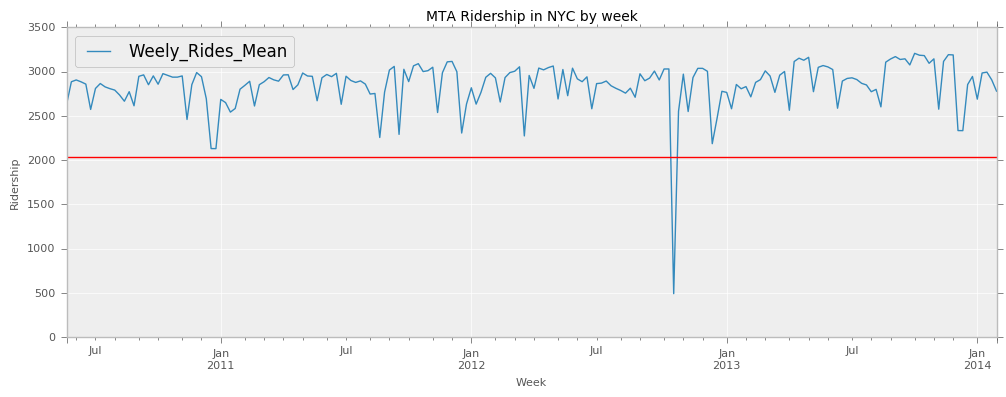

In [140]:
ax = weeklymean.plot(figsize=(12,4), fontsize=8, linewidth=1.0)
#ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[0], thresholds[0]], 'r-')
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [thresholds[1], thresholds[1]], 'r-', linewidth=1.0)
ax.set_title('MTA Ridership in NYC by week', fontsize=10)
ax.set_xlabel('Week', fontsize=8)
ax.set_ylabel('Ridership', fontsize=8)

Figure 2: A significant drop > 3 sigma, which could be flagged as an event.

In [16]:
# find the exact date of the event
weeklymean.loc[(weeklymean.Weely_Rides_Mean < thresholds[1])]

,Weely_Rides_Mean
2012-10-21,493.259546


### Conclusion
The date of this significant event is around 2012-10-21 to 2012-10-29. 
It was the week that Hurricane Sandy hitted New York. 

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

### Data shaping

In [17]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [18]:
# reshape the np.array to fit dataframe
mta_card = np.nanmean(mtarides, axis=0).T
mta_card.shape

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


(194, 23)

In [19]:
df_ridetype = DataFrame(mta_card, index=Date, columns=ridetype )

In [20]:
df_ridetype.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,umlim,xbus,stud
2010-05-23,24880.119048,1148.320346,103.465368,403.790043,101.316017,8003.123377,18510.686147,21.781385,721.205628,1108.294372,...,266.523810,1710.194805,129.456710,61.084416,0.00000,269.898268,45.584416,13.264069,0.774892,NaN
2010-05-30,27173.229935,1265.798265,111.683297,432.167028,139.594360,8637.327549,20577.861171,25.698482,613.351410,1253.845987,...,329.605206,1969.778742,150.127983,70.136659,0.00000,264.019523,47.006508,13.275488,1.028200,NaN
2010-06-06,27573.708423,1266.077754,111.524838,431.248380,123.097192,8710.647948,20467.684665,26.516199,652.328294,1329.453564,...,327.295896,1974.349892,150.267819,70.449244,0.00000,263.889849,46.291577,14.017279,1.004320,NaN
2010-06-13,27329.751620,1215.123110,112.447084,424.166307,80.840173,8710.049676,20410.542117,24.235421,659.855292,1309.438445,...,317.697624,1949.349892,147.082073,69.987041,0.00000,263.609071,46.717063,14.233261,1.045356,NaN
2010-06-20,27607.099138,1182.883621,110.243534,420.006466,75.883621,8460.012931,20030.176724,22.661638,723.663793,1214.323276,...,297.172414,1843.907328,143.053879,68.821121,0.37931,258.137931,43.743534,13.605603,0.974138,NaN


### Visulization of the trend

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).mean()
  from ipykernel import kernelapp as app
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


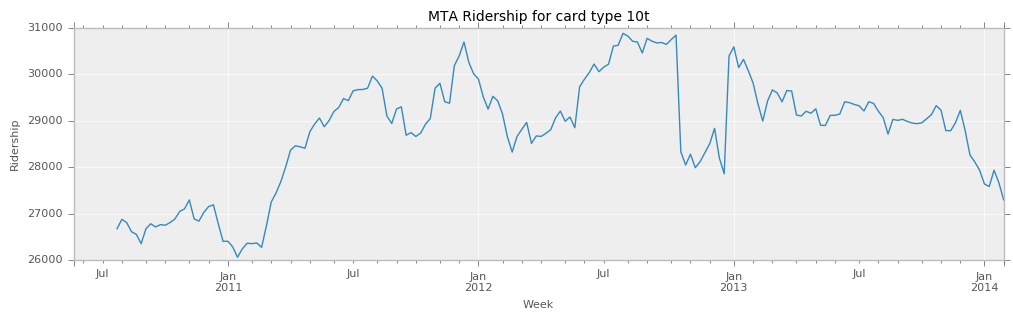

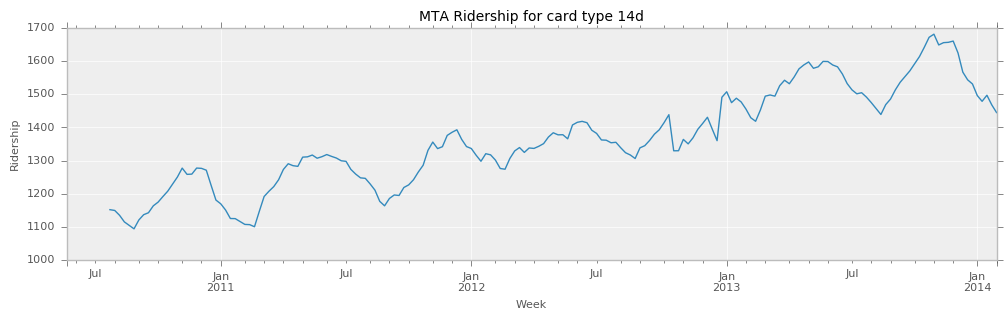

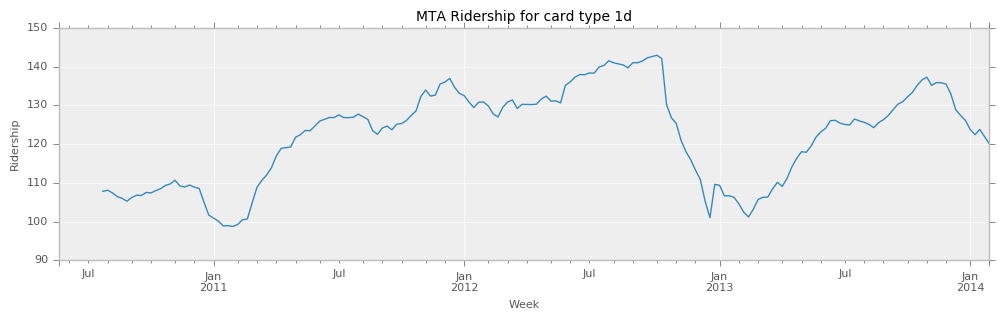

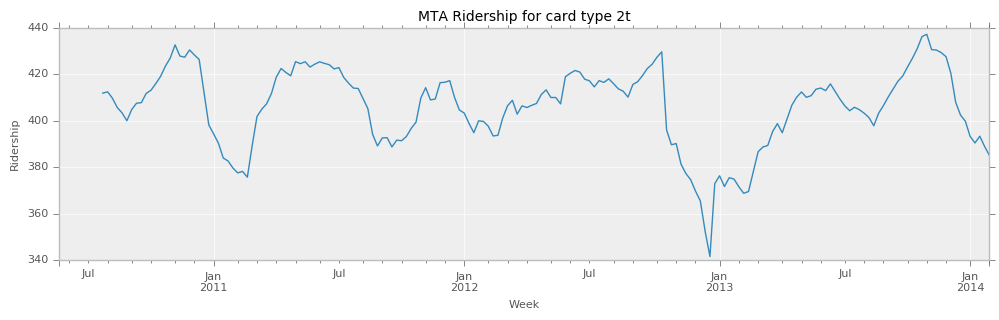

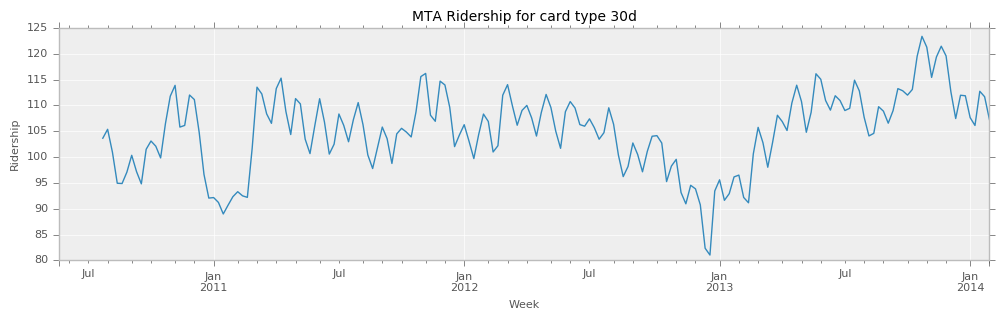

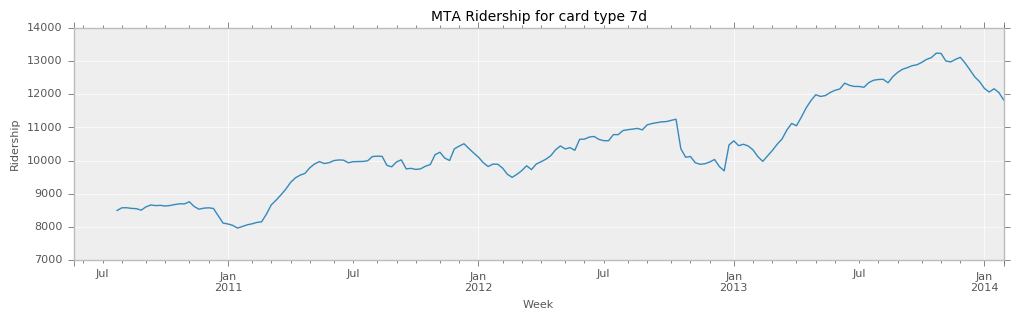

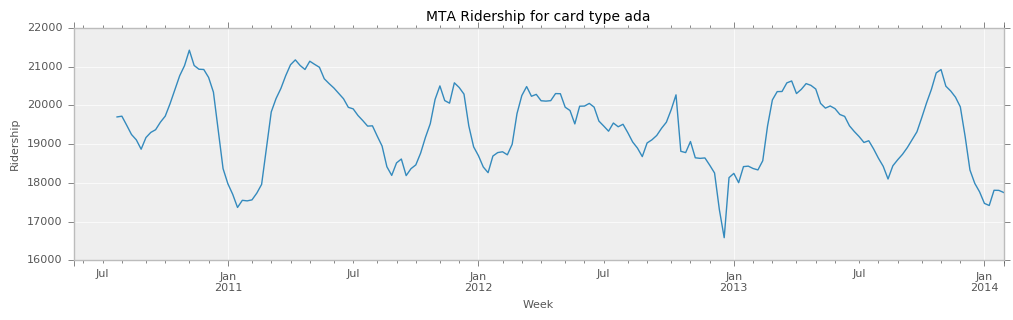

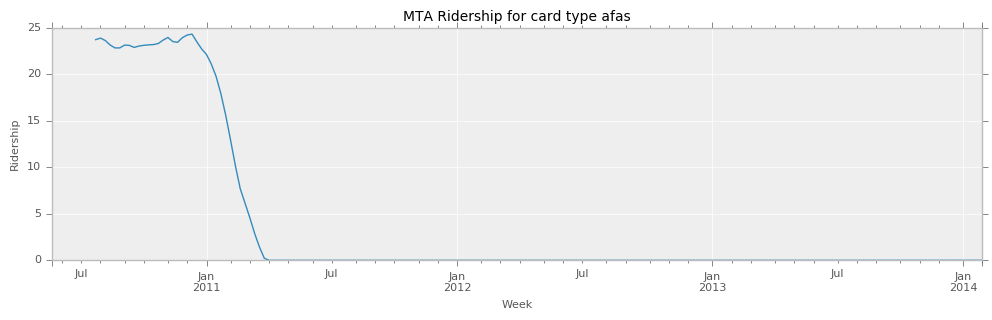

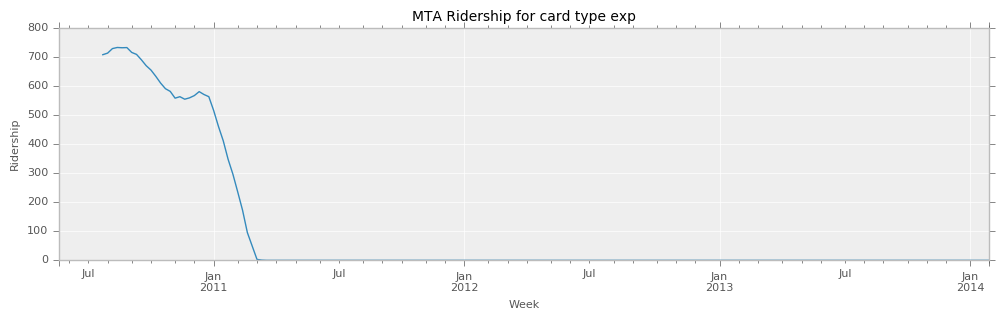

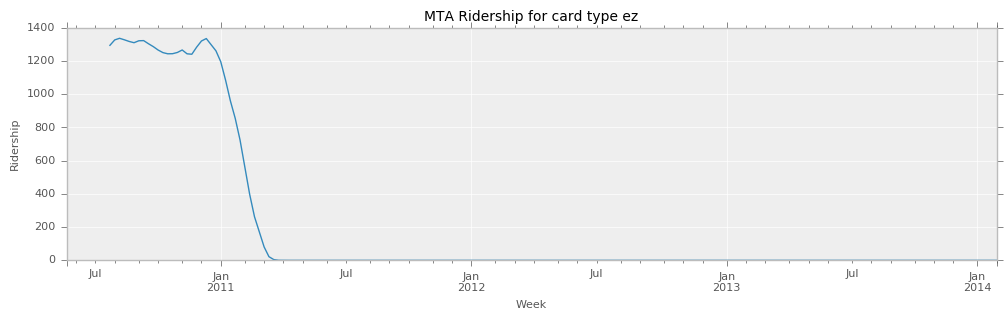

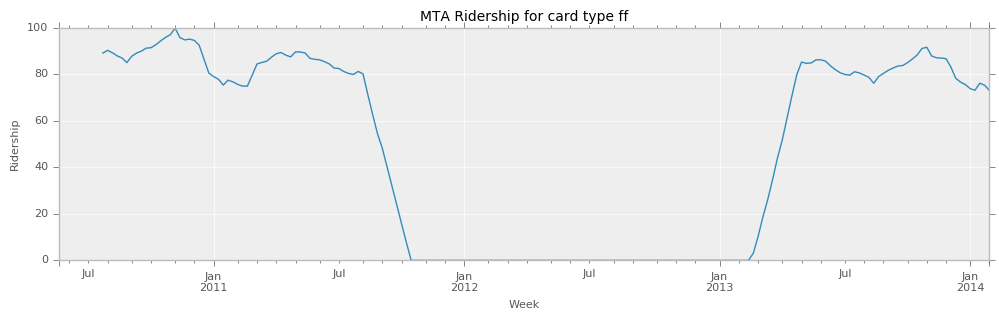

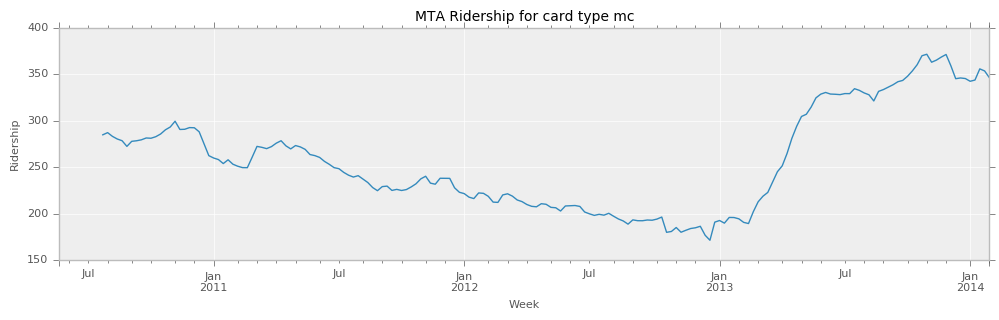

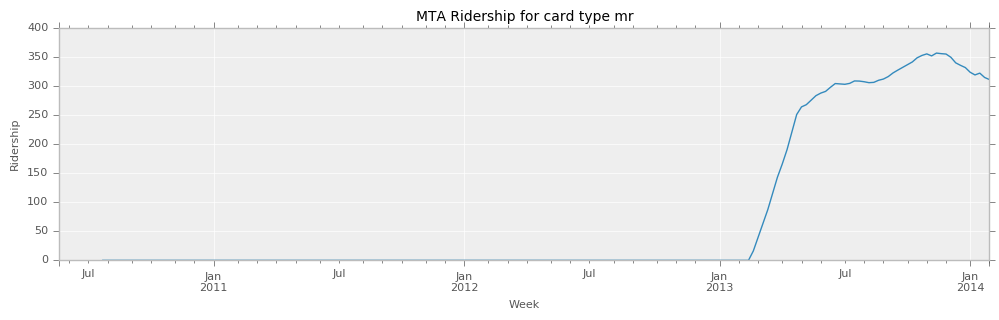

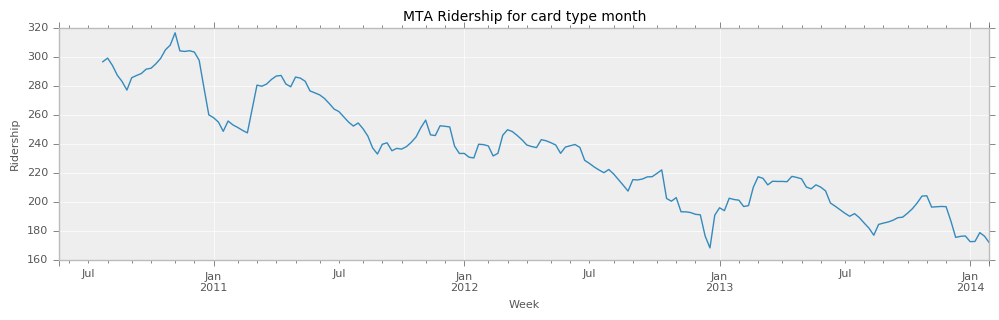

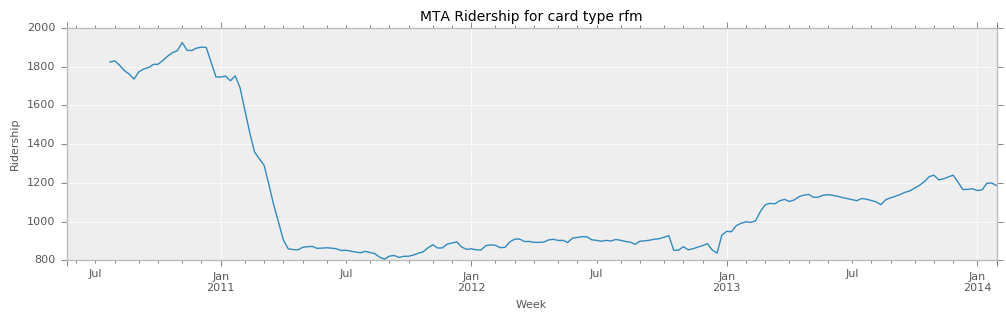

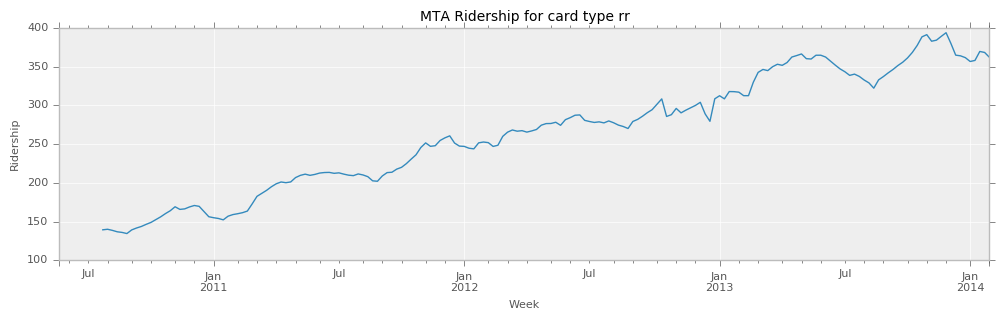

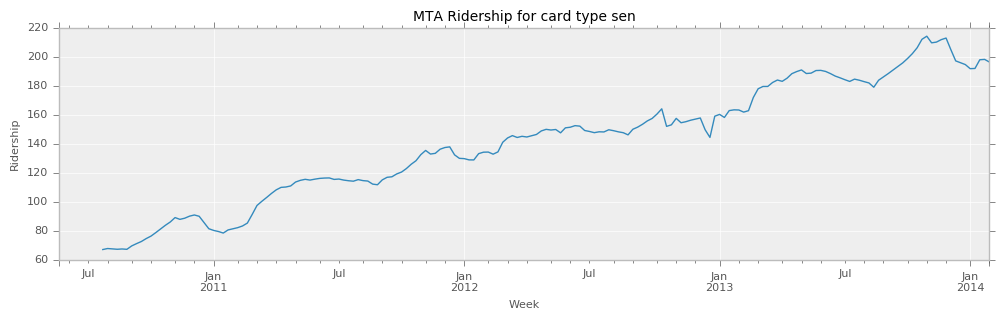

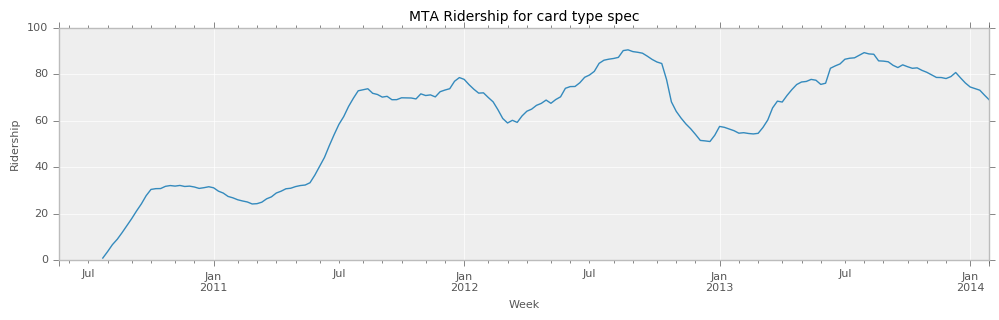

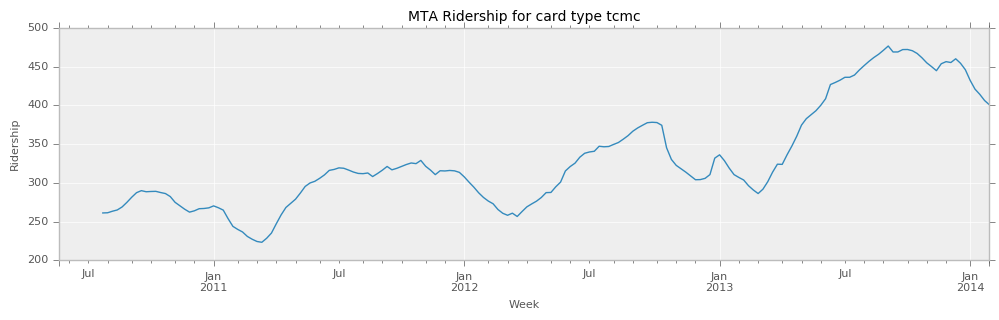

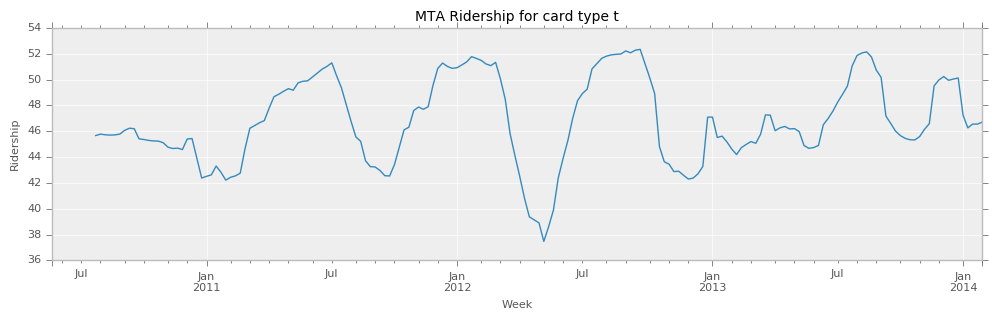

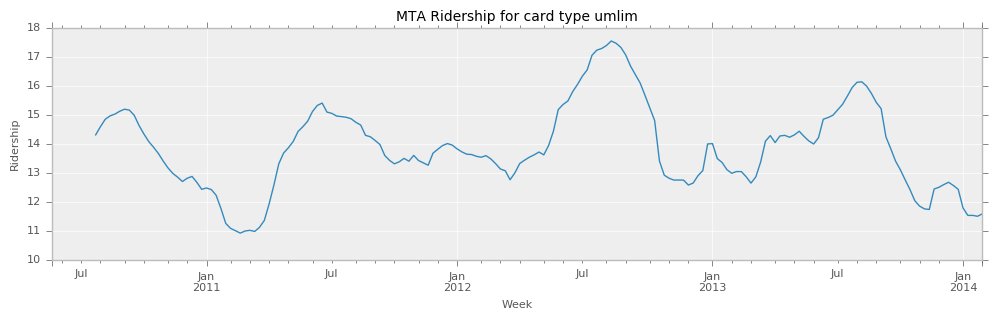

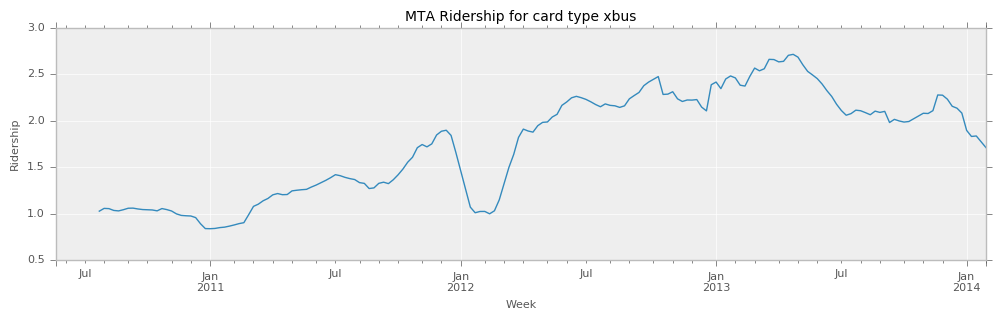

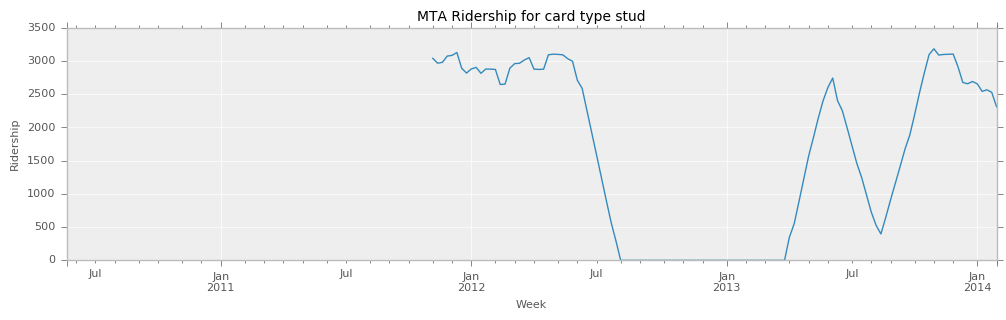

In [142]:
for i in ridetype:
    ax = pd.rolling_mean(df_ridetype['%s' %(i)], 10).plot(figsize=(12,3), fontsize=8, linewidth=1.0)
    ax.set_title('MTA Ridership for card type %s' %(i), fontsize=10)
    pl.xlabel('Week', fontsize=8)
    pl.ylabel("Ridership", fontsize=8)
    pl.figure()

Figures - MTA Ridership of each card type by week

### Observation
Inspect continued increase trends in card type 14d, 7d, 44 and sen. 
Inspect downward trend in card type month.

### Algorism - flux ratio

In [22]:
trendtype = np.array(['14d','7d','rr','sen','month'])

In [23]:
for i in trendtype:  
    print ('Flux ratio of card type %s:'%(i), df_ridetype['%s' %(i)][0:10].mean() / df_ridetype['%s' %(i)][-10:].mean())

Flux ratio of card type 14d: 0.797624276433
Flux ratio of card type 7d: 0.71859382072
Flux ratio of card type rr: 0.385131221691
Flux ratio of card type sen: 0.343247655191
Flux ratio of card type month: 1.72560081441


### Conclusion
There is a constant upward trend in - 
- 14 Day Card
- 7 Day Card
- Rail Road Card
- Senior Citizen/Disabled Card

And a constant downward trend in -
- Monthly Card

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [24]:
# preparing data
mta_station = np.nanmean(mtarides, axis=1)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [25]:
df_station = DataFrame(mta_station.T)
df_station.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,5767.181818,1695.727273,300.272727,744.454545,843.818182,908.500000,565.863636,504.136364,476.454545,6690.318182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6794.409091,2112.000000,312.772727,791.272727,904.681818,937.500000,620.181818,529.954545,501.363636,7037.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6926.500000,2243.590909,328.590909,799.772727,906.727273,964.772727,623.590909,547.136364,494.590909,7089.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7280.681818,2038.590909,260.500000,647.363636,730.727273,791.454545,520.909091,445.863636,414.681818,7041.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7392.772727,1886.772727,319.636364,799.500000,921.954545,950.409091,640.636364,542.909091,496.500000,7164.909091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Visualize power spectrum for 600 stations

In [26]:
import matplotlib.pyplot as plt

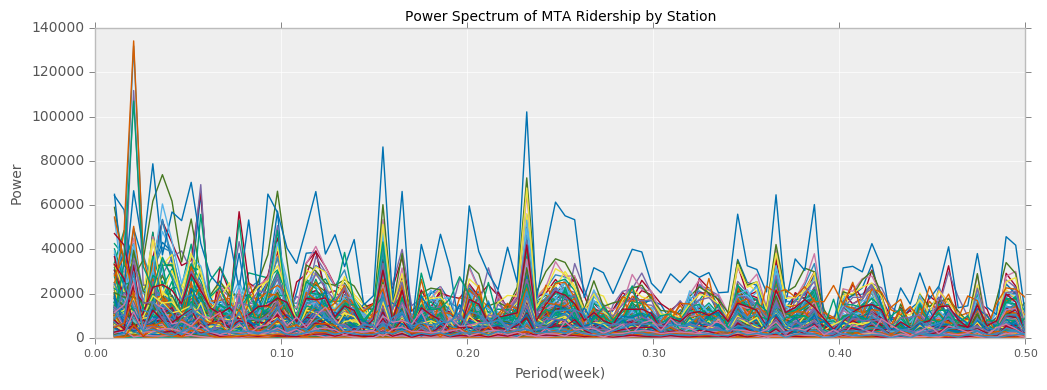

In [144]:
fig = plt.figure(figsize=(12,4))
periodic = []
for i in range(len(df_station.columns)):
    f = np.abs(np.fft.rfft(df_station[i]))
    periodic.append(f[4])
    ax = fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(194)[2:], f[2:], '-', linewidth=1.0)
ax.set_xticklabels([ "%.2f"%(f) for f in ax.get_xticks()], fontsize=8)
pl.xlabel('Period(week)', fontsize=10)
pl.ylabel('Power', fontsize=10)
pl.title('Power Spectrum of MTA Ridership by Station', fontsize=10)

Figure 3

### Identify top-4 station with annual periodicity

In [58]:
#source coder: Yao Wang (yw2278)
periodic = np.array(periodic)
sort = np.argsort(periodic)[::-1]
mask = np.where(~np.isnan(periodic[sort]))[0]
stations = sort[mask][:4]

### Conclusion

In [60]:
print ('Top 4 stations with the most prominent periodic trend on an annual period: {}'.format(stations))

Top 4 stations with the most prominent periodic trend on an annual period: [194 150  32 327]


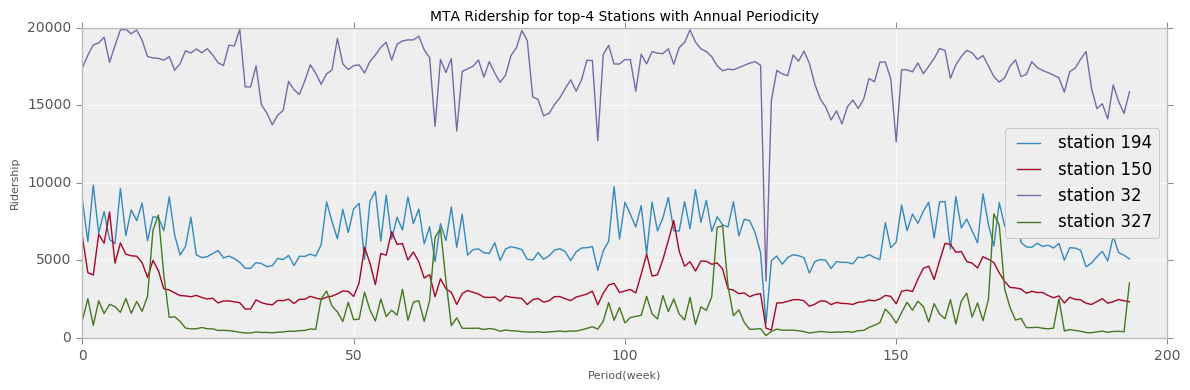

In [146]:
# visualize 
fig = plt.figure(figsize = (14,4))
for i in stations:
    plt.plot(df_station[i], label = 'station '+str(i), linewidth=1.0)
plt.title('MTA Ridership for top-4 Stations with Annual Periodicity', fontsize=10)
plt.ylabel("Ridership", fontsize=8)
plt.xlabel("Period(week)", fontsize=8)
plt.legend(loc = "best")

Figure 4




## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

In [88]:
tots = mtarides.transpose(2,0,1).reshape(mtarides.shape[2], mtarides.shape[1]*mtarides.shape[0]).T

In [89]:
tots = tots[tots.std(1)>0]

In [93]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

In [74]:
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans

In [75]:
def elbow(data,K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

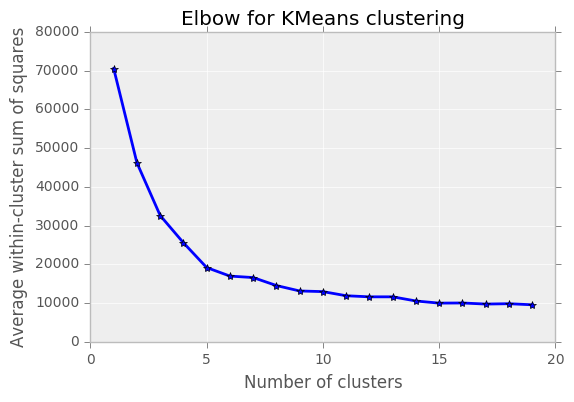

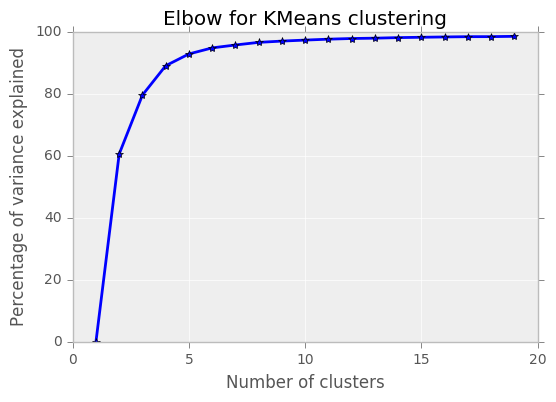

In [148]:
elbow(tots, range(1,20))

In [117]:
from sklearn.cluster import KMeans

n = 4 # number of clusters

km = KMeans(random_state=324, n_clusters=n)
res = km.fit(vals)

print(res.labels_)

[3 3 3 ..., 1 1 1]


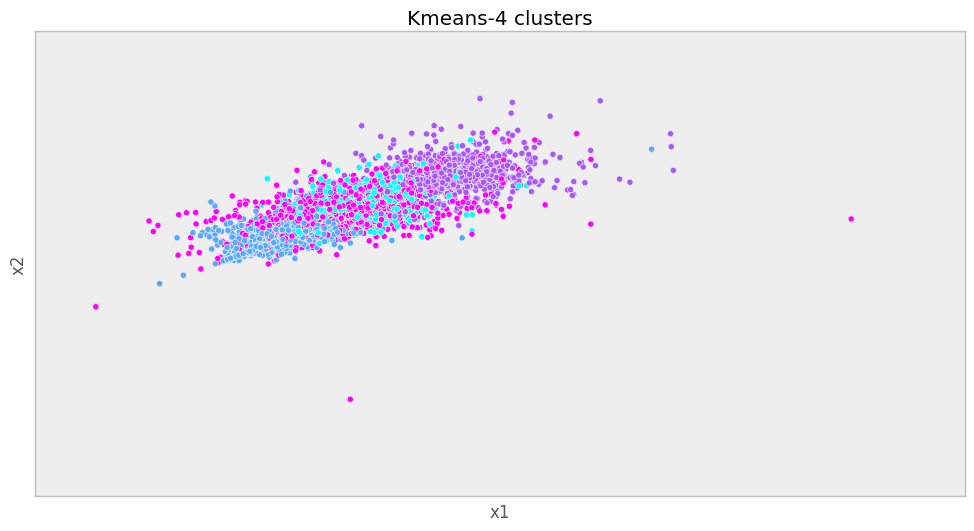

In [149]:
#Plot
plt.figure(figsize=(12,6))
plt.scatter(vals[:, 0], vals[:, 1], c=res.labels_, cmap=plt.cm.cool)
plt.xlabel('x1')
plt.ylabel('x2')
plt.xticks(())
plt.yticks(())
plt.title("Kmeans-{} clusters".format(n))
plt.show()